In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

import matplotlib.cm as cm

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np

from PIL import Image

from brainiac.loader import ADNIClassificationDataset
from brainiac.utils import load_model
from brainiac.models import *
from brainiac.grad_cam import GradCAM

In [4]:
import cv2
from IPython.display import clear_output

In [5]:
def from_3d_img_to_frames(img):
    img = img.squeeze(0).squeeze(0)
    frames = [Image.fromarray(np.uint8(img.numpy()[i] * 255)) for i in range(img.shape[0])]
    frames = [fr.convert('P', palette = Image.ADAPTIVE) for fr in frames]
    return frames

In [6]:
def save_gif(images, path, duration=0.1):
    images[0].save(path, save_all=True, append_images=images[1:],
                   optimize=False, duration=duration, loop=0)

In [7]:
def make_regions_from(model, images, target_layers, target_class=None, mode='3D'):
    
    gcam = GradCAM(model, target_layers, mode=mode)
    
    probs, ids = gcam.forward(images)
    
    if target_class is None:
        target_class = ids[0, 0]
        
    ids_ = torch.LongTensor([[target_class]] * len(images))
    gcam.backward(ids=ids_)
    
    regions = gcam.generate(target_layer=target_layers[-1])
    
    gcam.remove_hook()
    
    regions[regions < 0.2] = 0
    return regions

In [8]:
def get_gradcam(gcam, raw_image, paper_cmap=False):
    gcam = gcam.cpu().numpy()
    cmap = cm.jet_r(gcam)[..., :3] * 255.0
    if paper_cmap:
        alpha = gcam[..., None]
        gcam = alpha * cmap + (1 - alpha) * raw_image
    else:
        gcam = (cmap.astype(np.float) + raw_image.astype(np.float)) / 2
     
    return np.uint8(gcam)

# Resnet

## Old data

In [11]:
path = '../ADNI-processed/data.csv'
images_path = '../ADNI-processed/images/'
df = pd.read_csv(path)
idx = 1008

In [12]:
dataset = ADNIClassificationDataset(df, images_path=images_path)

raw_image = np.uint8(dataset[idx][0][0] * 255)
raw_image = [cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) for img in raw_image]

images = dataset[idx][0].unsqueeze(0)

In [35]:
# model = resnet152(num_classes=2)
# model, _ = load_model(model, 'trained_model/ResNet152/classes-CN-AD_optim-Adam_aug-1_sampling-1_lr-5e-05_scheduler-0_pretrain-1/model_epoch199.pth')
# _ = model.eval()

model = resnet50(num_classes=2)
model, _ = load_model(model, 'trained_model/ResNet50/classes-CN-AD_optim-Adam_aug-1_sampling-1_lr-0.001_scheduler-0_pretrain-1/model_epoch151.pth')
_ = model.eval()

In [48]:
layer_name = 'layer1'
regions = make_regions_from(model, images, target_layers=[layer_name], target_class=1, mode='3D')

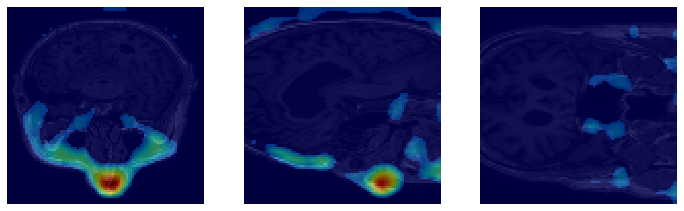

In [68]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))


i = 90
raw_image = cv2.cvtColor(np.uint8(images[0, 0, i, :, :] * 255), cv2.COLOR_GRAY2RGB)
gcam = get_gradcam(1 - regions[0, 0, i], raw_image)
gcam = cv2.resize(gcam, (96, 96))
ax[0].imshow(np.rot90(gcam))
ax[0].axis('off')

i = 53
raw_image = cv2.cvtColor(np.uint8(images[0, 0, :, i, :] * 255), cv2.COLOR_GRAY2RGB)
gcam = get_gradcam(1 - regions[0, 0, :, i, :], raw_image)
gcam = cv2.resize(gcam, (96, 96))
ax[1].imshow(np.rot90(gcam))
ax[1].axis('off')

i = 54
raw_image = cv2.cvtColor(np.uint8(images[0, 0, :, :, i] * 255), cv2.COLOR_GRAY2RGB)
gcam = get_gradcam(1 - regions[0, 0, :, :, i], raw_image)
gcam = cv2.resize(gcam, (96, 96))
ax[2].imshow(np.rot90(gcam))
ax[2].axis('off')

# plt.savefig('pics/gradcam.pdf')
plt.show()

## Cut data

In [ ]:
path = '../ADNI_cut/data.csv'
images_path = '../ADNI_cut/images/'
df = pd.read_csv(path)
idx = 1008

In [ ]:
dataset = ADNIClassificationDataset(df, images_path=images_path)

raw_image = np.uint8(dataset[idx][0][0] * 255)
raw_image = [cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) for img in raw_image]

images = dataset[idx][0].unsqueeze(0)

In [ ]:
model = resnet152(num_classes=2)
model, _ = load_model(model, 'trained_model/ResNet152/pretrain_resnet.pth')
_ = model.eval()

In [ ]:
layer_name = 'layer2'
regions = make_regions_from(model, images, target_layers=[layer_name], target_class=1, mode='3D')

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))


i = 40
raw_image = cv2.cvtColor(np.uint8(images[0, 0, i, :, :] * 255), cv2.COLOR_GRAY2RGB)
gcam = get_gradcam(1 - regions[0, 0, i], raw_image)
gcam = cv2.resize(gcam, (96, 96))
ax[0].imshow(np.rot90(gcam))
ax[0].axis('off')

i = 54
raw_image = cv2.cvtColor(np.uint8(images[0, 0, :, i, :] * 255), cv2.COLOR_GRAY2RGB)
gcam = get_gradcam(1 - regions[0, 0, :, i, :], raw_image)
gcam = cv2.resize(gcam, (96, 96))
ax[1].imshow(np.rot90(gcam))
ax[1].axis('off')

i = 66
raw_image = cv2.cvtColor(np.uint8(images[0, 0, :, :, i] * 255), cv2.COLOR_GRAY2RGB)
gcam = get_gradcam(1 - regions[0, 0, :, :, i], raw_image)
gcam = cv2.resize(gcam, (96, 96))
ax[2].imshow(np.rot90(gcam))
ax[2].axis('off')

plt.savefig('pics/gradcam.pdf')
plt.show()

## gif

In [ ]:
gif = []
for i in list(range(0, 128)) + list(reversed(range(0, 128))):
    raw_image = cv2.cvtColor(np.uint8(images[0, 0, i, :, :] * 255), cv2.COLOR_GRAY2RGB)
    gcam = get_gradcam(1 - regions[0, 0, i, :, :], raw_image)
    gcam = np.rot90(cv2.resize(gcam, (128, 128)))
    gif.append(Image.fromarray(gcam))
save_gif(gif, 'pics/gradcam_gif_1.gif')

gif = []
for i in list(range(15, 80)) + list(reversed(range(15, 80))):
    raw_image = cv2.cvtColor(np.uint8(images[0, 0, :, i, :] * 255), cv2.COLOR_GRAY2RGB)
    gcam = get_gradcam(1 - regions[0, 0, :, i, :], raw_image)
    gcam = np.rot90(cv2.resize(gcam, (128, 128)))
    gif.append(Image.fromarray(gcam))
save_gif(gif, 'pics/gradcam_gif_2.gif')

gif = []
for i in list(range(15, 83)) + list(reversed(range(15, 83))):
    raw_image = cv2.cvtColor(np.uint8(images[0, 0, :, :, i] * 255), cv2.COLOR_GRAY2RGB)
    gcam = get_gradcam(1 - regions[0, 0, :, :, i], raw_image)
    gcam = np.rot90(cv2.resize(gcam, (128, 128)))
    gif.append(Image.fromarray(gcam))
save_gif(gif, 'pics/gradcam_gif_3.gif')